aqi사이트:https://aqicn.org/city/korea/seoul/gwanak-gu/

위의 사이트에서 각자 좋아하는 관악구의 pm25와 pm10의 월별 aqi 시계열도를 그리고 최적의 sarima 모델을 찾아라!

trainset = 처음 데이터 ~ 최근 6개월 데이터

testset = 최근 6개월 데이터

hint:

- groupby를 쓰면 월별 지표를 구하기 쉽습니다.
- 결측치를 처리할 방법을 생각해 보세요!
- 예측값이 좋지 않다면 예측 설명을 해주실수 있으면 좋습니다! (ex 코로나..)

# PM2.5

In [1]:
#셀레니움으로 웹페이지 크롤링
from selenium import webdriver # 자바스크립트로 전송 되는 데이터는 url - html에 안붙어있습니다.. 페이지를 열어줘야 데이터가 와요!
from selenium.webdriver.chrome.options import Options 
import time
import requests
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup as bs
import lxml


path = './chromedriver_nonhl' 

driver = webdriver.Chrome(path)

driver.get("https://aqicn.org/city/korea/seoul/gwanak-gu/")

air_pollution_html = driver.page_source


In [3]:
#웹페이시 html 소스 가져오기
air_pollution_html = driver.page_source
soup = bs(air_pollution_html, "lxml")

In [132]:
#월 태그 리스트 만들기
months = ['201407','201408','201409','201410','201411']
for i in range(15,20):
    for j in range(12):
        months.append(('20'+'%2s'%str(i)+'%2s'%str(j)).replace(' ','0'))
for i in range(9):
    months.append(('2020'+'%2s'%str(i)).replace(' ','0'))

In [133]:
#aqi 데이터 가져오기
aqi_data = []
for j in months:
    obj_squares = soup.find("tr", {"key":j}).find("td",{"class":"squares"})
    aqi_month = obj_squares.find_all("text")
    aqi_mon_li = []
    for i in range(len(aqi_month)):
        aqi_value = aqi_month[i].text
        if aqi_value.isnumeric():
            aqi_mon_li.append(int(aqi_value))
        else:
            aqi_mon_li.append(float('nan'))
    aqi_data.append(aqi_mon_li)

,aqi_mean_month,month
0,59.655172,2014-08-01
1,59.100000,2014-09-01
2,56.225806,2014-10-01
3,64.000000,2014-11-01
4,53.620690,2014-12-01
...,...,...
69,57.870968,2020-05-01
70,67.766667,2020-06-01
71,44.741935,2020-07-01
72,50.935484,2020-08-01


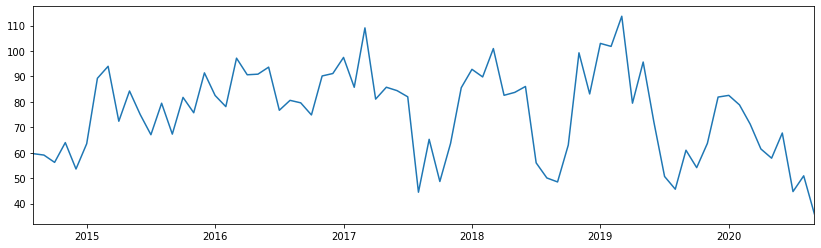

In [134]:
#월별 aqi 평균을 구하고 데이터프레임에 저장
#해당 평균 데이터로 시계열도 작성

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas as pd


for i in range(len(aqi_data)):
    aqi_data[i] = [aqi_data[i] for aqi_data[i] in aqi_data[i] if str(aqi_data[i]) != 'nan']

month = []
for i in range(8,13):
    month.append(datetime.datetime(2014,i,1))
for i in range(2015,2020):
    for j in range(1,13):
       month.append(datetime.datetime(i,j,1))
for i in range(1,10):
    month.append(datetime.datetime(2020,i,1))

aqi_mean_month = list(map(lambda x: sum(x)/len(x),aqi_data))
df = pd.DataFrame({'aqi_mean_month' : aqi_mean_month, 'month':month})
plt.figure(figsize=(14,4))
plt.xlim(0,73)
plt.xticks([5,17,29,41,53,65],[2015,2016,2017,2018,2019,2020])
plt.plot(list(range(len(aqi_mean_month))),aqi_mean_month)
df

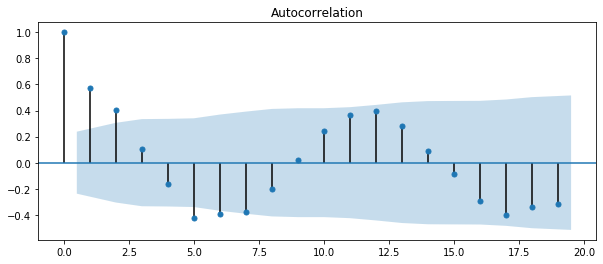

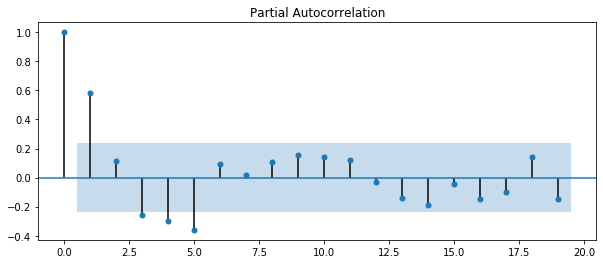

In [135]:
# acf
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

trainset = df[0:68]
testset = df[68:]

y = trainset.aqi_mean_month

plt.rc("figure", figsize=(10,4))
fig = plot_acf(y)
fig = plot_pacf(y)

In [136]:
# adfuller test - 단위근검정
import statsmodels.api as sm

result = sm.tsa.stattools.adfuller(y, maxlag = 1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# p-value 0.0005
# H_0 기각, 단위근 존재하지 않음.
# 차수가 1이 있다.

ADF Statistic: -4.255198
p-value: 0.000531
Critical Values:
	1%: -3.532
	5%: -2.906
	10%: -2.590


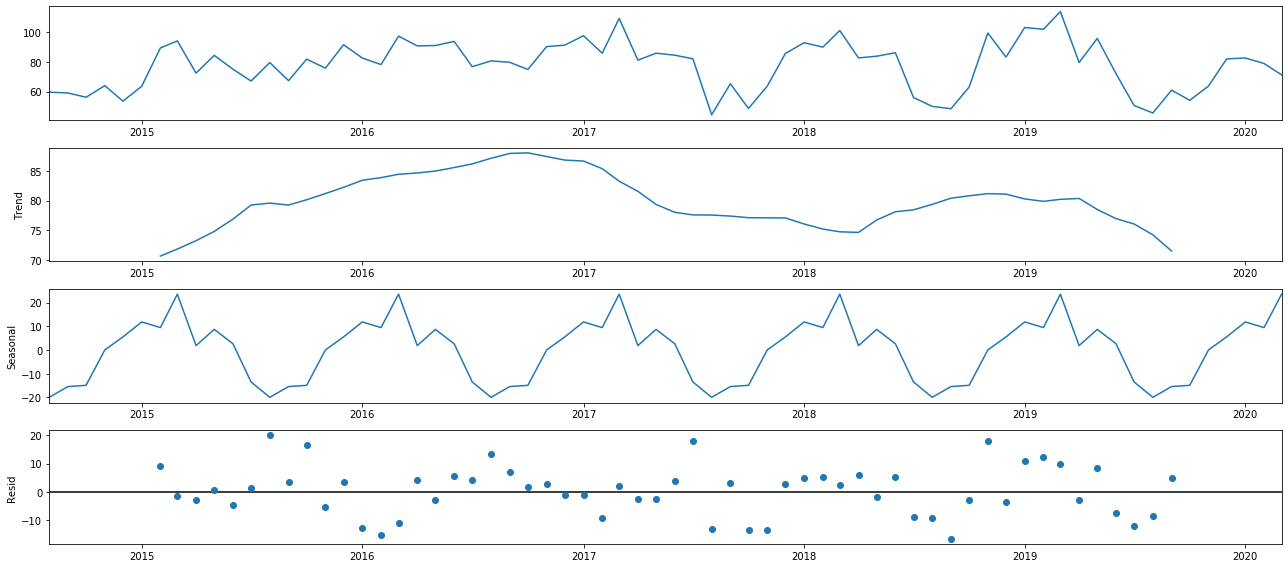

In [137]:
from pylab import rcParams

y = trainset.set_index("month")

rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

#Trend에 일정한 경향이 보이지 않음

In [138]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [164]:
#최적의 aic값을 갖는 parameter 구하기

aic_list=[]
param_list=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            aic_list.append(results.aic)
            param_list.append([param,param_seasonal])

        except: 
            continue

param_list[aic_list.index(min(aic_list))]


so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.p

[(0, 1, 1), (0, 1, 1, 12)]

In [165]:
#최적의 값으로 fitting

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5328      0.217     -2.450      0.014      -0.959      -0.107
ma.S.L12      -0.6324      0.293     -2.161      0.031      -1.206      -0.059
sigma2       172.3206     33.808      5.097      0.000     106.057     238.584
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


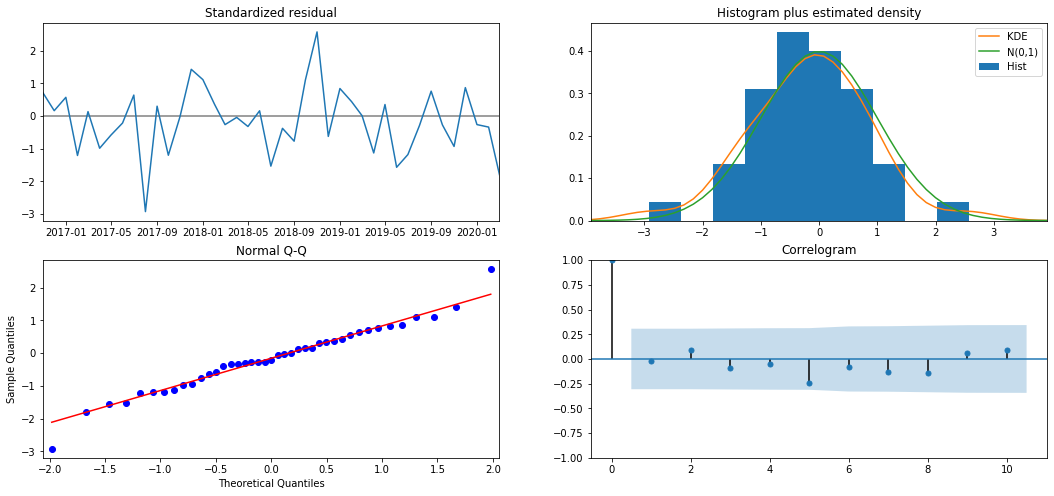

In [166]:
#모델 분석

results.plot_diagnostics(figsize=(18, 8))
plt.show()

#잔차와 Q-Q플롯이 적당해 보임

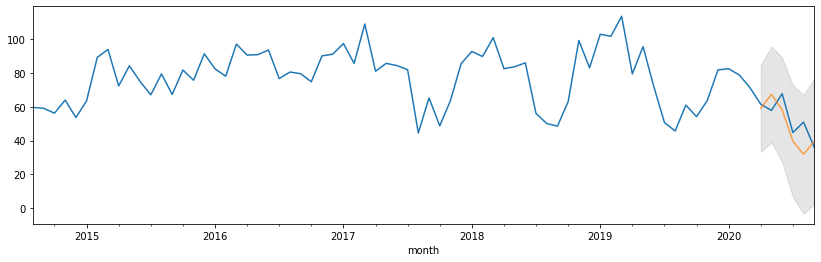

In [169]:
pred = results.get_forecast(steps=6).summary_frame()
df_i = df.set_index('month')
ax = df_i.aqi_mean_month.plot(label='observed')
pred['mean'].plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred.index,
                pred['mean_ci_upper'], 
                pred['mean_ci_lower'], color='k', alpha=0.1)

## 결론

조금의 차이가 있지만 하강의 경향성을 잘 보여준다는 점에서 적절한 예측값을 보여줬다고 해석할 수 있음

# PM10

In [83]:
#웹페이시 html 소스 가져오기
air_pollution_html_pm10 = driver.page_source
soup2 = bs(air_pollution_html_pm10, "lxml")

In [145]:
#월 태그 리스트 만들기
months2 = []
for i in range(14,20):
    for j in range(12):
        months2.append(('20'+'%2s'%str(i)+'%2s'%str(j)).replace(' ','0'))
for i in range(9):
    months2.append(('2020'+'%2s'%str(i)).replace(' ','0'))

In [146]:
#aqi 데이터 가져오기
aqi_data2 = []
for j in months2:
    obj_squares = soup2.find("tr", {"key":j}).find("td",{"class":"squares"})
    aqi_month = obj_squares.find_all("text")
    aqi_mon_li = []
    for i in range(len(aqi_month)):
        aqi_value = aqi_month[i].text
        if aqi_value.isnumeric():
            aqi_mon_li.append(int(aqi_value))
        else:
            aqi_mon_li.append(float('nan'))
    aqi_data2.append(aqi_mon_li)

,aqi_mean_month,month
0,50.300000,2014-01-01
1,44.107143,2014-02-01
2,52.225806,2014-03-01
3,50.866667,2014-04-01
4,51.548387,2014-05-01
...,...,...
76,30.354839,2020-05-01
77,33.100000,2020-06-01
78,20.548387,2020-07-01
79,22.000000,2020-08-01


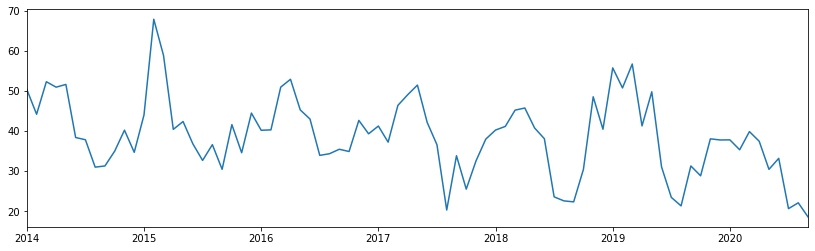

In [147]:
#월별 aqi 평균을 구하고 데이터프레임에 저장
#해당 평균 데이터로 시계열도 작성

for i in range(len(aqi_data2)):
    aqi_data2[i] = [aqi_data2[i] for aqi_data2[i] in aqi_data2[i] if str(aqi_data2[i]) != 'nan']

month2 = []
for i in range(2014,2020):
    for j in range(1,13):
       month2.append(datetime.datetime(i,j,1))
for i in range(1,10):
    month2.append(datetime.datetime(2020,i,1))

aqi_mean_month2 = list(map(lambda x: sum(x)/len(x),aqi_data2))
df2 = pd.DataFrame({'aqi_mean_month' : aqi_mean_month2, 'month':month2})
plt.figure(figsize = (14,4))
plt.xticks([0,12,24,36,48,60,72],[2014,2015,2016,2017,2018,2019,2020])
plt.xlim(0,80)
plt.plot(list(range(len(aqi_mean_month2))),aqi_mean_month2)
df2

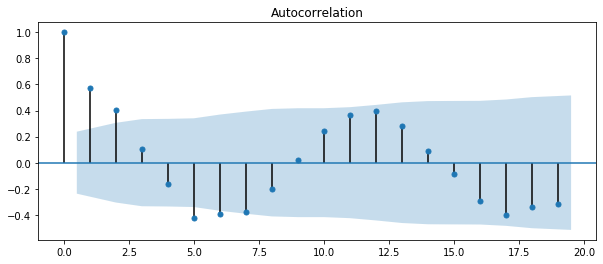

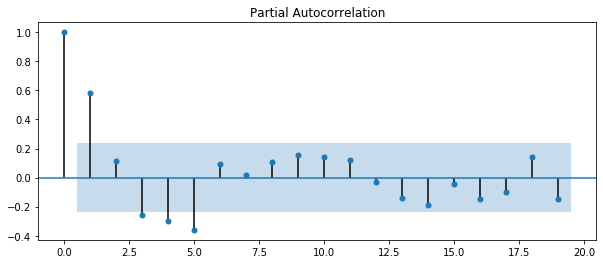

In [148]:
# acf

trainset2 = df2[:-6]
testset2 = df2[-6:]

y2 = trainset2.aqi_mean_month

plt.rc("figure", figsize=(10,4))
fig2 = plot_acf(y)
fig2 = plot_pacf(y)


In [149]:
# adfuller test - 단위근검정

result2 = sm.tsa.stattools.adfuller(y2, maxlag = 1)
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
print('Critical Values:')
for key, value in result2[4].items():
    print('\t%s: %.3f' % (key, value))

# p-value 0.0003
# H_0 기각, 단위근 존재하지 않음.
# 차수가 1이 있다.

ADF Statistic: -4.332186
p-value: 0.000391
Critical Values:
	1%: -3.522
	5%: -2.901
	10%: -2.588


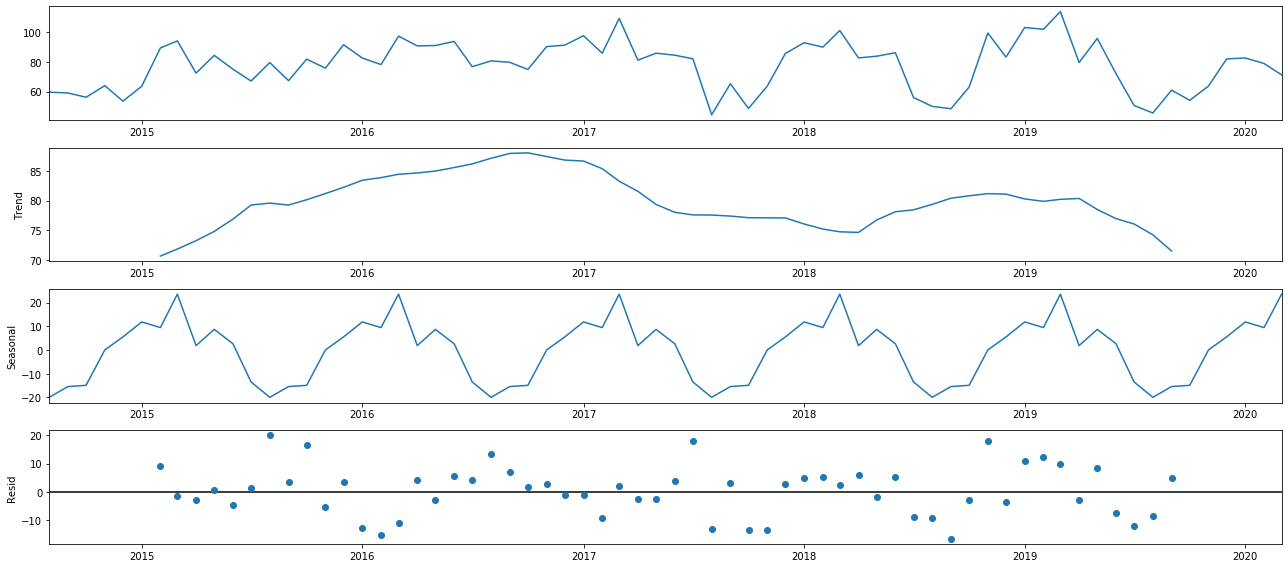

In [150]:
y2 = trainset2.set_index("month")

rcParams['figure.figsize'] = 18, 8

decomposition2 = sm.tsa.seasonal_decompose(y, model='additive')
fig2 = decomposition2.plot()
plt.show()

#Trend에 일정한 경향이 보이지 않음

In [176]:
p2 = d2 = q2 = range(0, 2)
pdq2 = list(itertools.product(p2, d2, q2))
seasonal_pdq2 = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq2[1], seasonal_pdq2[1]))
print('SARIMAX: {} x {}'.format(pdq2[1], seasonal_pdq2[2]))
print('SARIMAX: {} x {}'.format(pdq2[2], seasonal_pdq2[3]))
print('SARIMAX: {} x {}'.format(pdq2[2], seasonal_pdq2[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [180]:
#최적의 aic값을 갖는 parameter 구하기

aic_list2 = []
param_list2 = []
for param in pdq2:
    for param_seasonal in seasonal_pdq2:
        try:
            mod = sm.tsa.statespace.SARIMAX(y2,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results2 = mod.fit()
            aic_list2.append(results2.aic)
            param_list2.append([param,param_seasonal])
        except: 
            continue

param_list2[aic_list2.index(min(aic_list2))]

rovided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/ts

[(1, 1, 1), (0, 1, 1, 12)]

In [186]:
#최적의 값으로 fitting

mod2 = sm.tsa.statespace.SARIMAX(y2,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results2 = mod2.fit()
print(results2.summary().tables[1])

/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/imingi/opt/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2782      0.205      1.355      0.175      -0.124       0.681
ma.L1         -1.0000   1381.624     -0.001      0.999   -2708.934    2706.934
ma.S.L12      -1.0001   1555.640     -0.001      0.999   -3049.999    3047.999
sigma2        28.6201   6.46e+04      0.000      1.000   -1.27e+05    1.27e+05


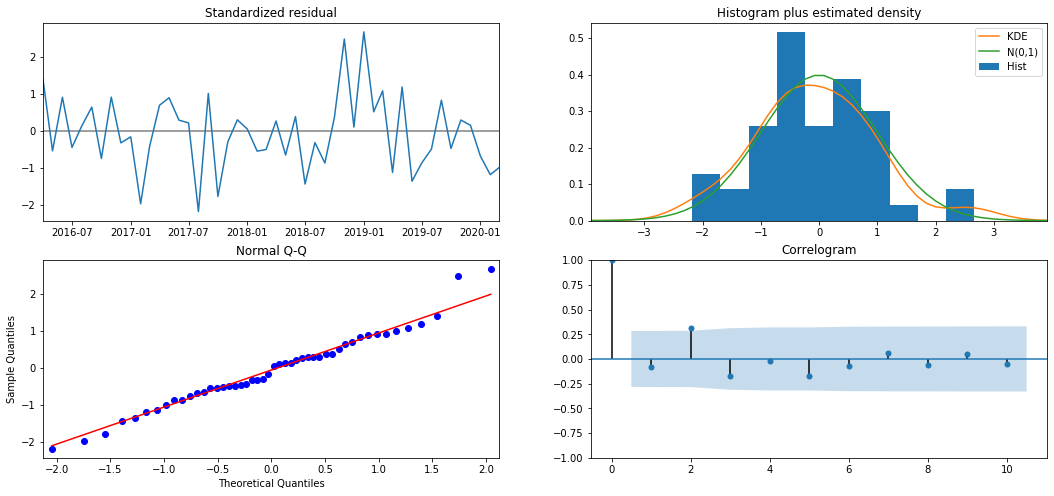

In [187]:
#모델 분석

results2.plot_diagnostics(figsize=(18, 8))
plt.show()

#잔차와 Q-Q플롯이 적당해 보임

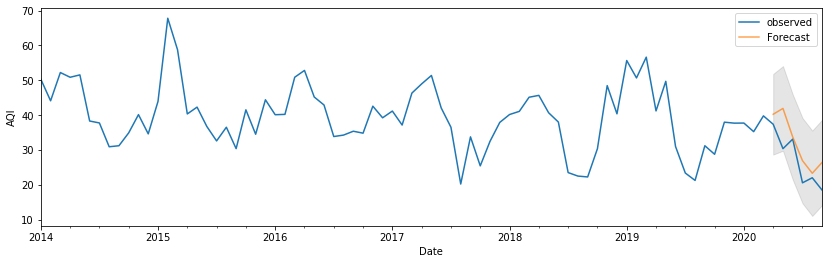

In [188]:
pred2 = results2.get_forecast(steps=6).summary_frame()
df_i2 = df2.set_index('month')
ax = df_i2.aqi_mean_month.plot(label='observed')
pred2['mean'].plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred2.index,
                pred2['mean_ci_upper'], 
                pred2['mean_ci_lower'], color='k', alpha=0.1)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

## 결론

하강의 경향성을 잘 보여줬지만 전반적으로 높은 값을 예측하고 있음 <br>
- 2020년 코로나 사태로 인한 중국 공장 가동 중단 등의 요인으로 예년보다 미세먼지량이 줄었다고 생각해볼 수 있음
